In [1]:
#Imports
import numpy as np
import h5py as h5
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 12

In [2]:
#datasets
data_path = '/projects/nikhil/ADNI_prediction/input_datasets/'

#input data
train_val_file = data_path + 'cli_ct_seg_fused_train_plus_val.pkl'
test_file = '/projects/francisco/data/ADNI/cli_ct_seg_fused_test.pkl'

#k-fold indices (from a saved file)
kf_file = data_path + 'cli_ct_train_valid_KFold_idx.pkl'


In [3]:
#Grab CV data with specific feature columes (independent vars) and specific clinical scale (dependent var)
def load_CV_data(in_file, kf_file, clinical_scales, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scales])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scales], dtype=float)
    kf = pickle.load( open(kf_file, "rb" ) )
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    var_names = data_trunc.filter(regex=all_vars).columns
    
    # Return train and validation lists comprising all folds
    return {'X_train':X_train,'X_valid':X_valid,'y_train':y_train,'y_valid':y_valid}, var_names

#Load test data
def load_test_data(in_file, clinical_scale, feature_cols):
    data = pd.read_pickle(in_file)
    all_regex = '|'.join(['^{}'.format(var) for var in feature_cols + clinical_scale])
    all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
    data_trunc = data.filter(regex=all_regex)
    data_trunc = data_trunc.dropna(how='any')
    X = np.asarray(data_trunc.filter(regex=all_vars), dtype=float)
    y = np.asarray(data_trunc[clinical_scale], dtype=float)
    return {'X':X, 'y':y}
    

In [86]:
feature_cols = ['CT', 'L_HC_VOL','R_HC_VOL']
clinical_scale = ['ADAS11', 'ADAS13', 'MMSE']

cv_data, var_names = load_CV_data(train_val_file,kf_file, clinical_scale, feature_cols)
test_data = load_test_data(test_file, clinical_scale, feature_cols)
print cv_data['X_train'][0].shape
print cv_data['y_train'][0].shape

(522, 76)
(522, 3)


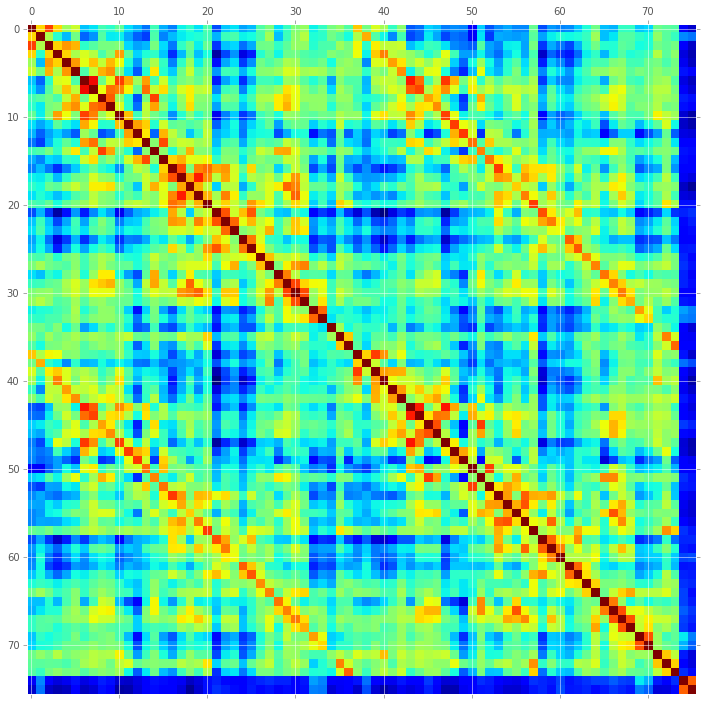

In [5]:
# Correlation matrix
data = pd.read_pickle(train_val_file)
all_vars = '|'.join(['^{}'.format(var) for var in feature_cols])
data_trunc = data.filter(regex =all_vars)
data_trunc = data_trunc.dropna(how='any')

plt.matshow(data_trunc.corr())




In [74]:
from sklearn.metrics import mean_squared_error

# Define a model
# Multitask lasso and multitask elastic net
# Space for hyperparam search
alphas=np.logspace(-5,5,num=100)

import scipy
from sklearn import linear_model
from sklearn.metrics import r2_score
BaseReg=linear_model.MultiTaskLasso
    
class Regression(BaseReg):
    def __init__(self, alpha=0.1, normalize=False, fit_intercept=True):
        super(Regression, self).__init__(alpha=0.1, normalize=False, fit_intercept=True)
    

    def fit(self, X, Y):
        self = super(Regression, self).fit(X,Y)
        df = X.shape[0] - X.shape[1] - 1
        Y_hat = self.predict(X)
        sse = np.sum(np.square(Y - Y_hat), axis=0)
        self.variance_Y = sse/df
        self.variance_X = (np.matrix(X).T * np.matrix(X)).I    
        
        self.zscores_ = self.coef_ / np.sqrt(self.variance_Y.reshape(-1,1) * self.variance_X.diagonal())
        self.pvals_ = 1 - scipy.stats.t.cdf(abs(self.zscores_), df)
    
    def score(self, X, Y):
        N, P = X.shape
        Y_hat = self.predict(X)
        score = super(Regression, self).score(X, Y)
        
        # R2 and adjusted R2:
        self.R2 = np.array([r2_score(Y[:,i], Y_hat[:,i]) for i in range(Y.shape[1])])
        self.rmse = np.array([np.sqrt(mean_squared_error(Y[:,i], Y_hat[:,i])) for i in range(Y.shape[1])])
        self.adj_R2 = self.R2 - (1 - self.R2) * ((N - 1) / (N - P - 1))
        
        self.var_Y = np.var(Y, axis=0)
        Y_bar = np.mean(Y,axis=0)
        
        self.ssm = np.sum(np.square(Y_hat - Y_bar))
        self.sse = np.sum(np.square(Y - Y_hat))
        self.sst = np.sum(np.square(Y - Y_bar))
        self.r = np.array([scipy.stats.pearsonr(Y[:,i], Y_hat[:,i]) for i in range(Y.shape[1])])
        
        return score
        

if BaseReg==linear_model.MultiTaskLasso:
    reg = Regression(alpha=0.1, normalize=False, fit_intercept=True)
else:
    reg = Regression(normalize=False, fit_intercept=True)

In [75]:
X = cv_data['X_train'][0]
Y = cv_data['y_train'][0]
X_v = cv_data['X_valid'][0]
Y_v = cv_data['y_valid'][0]
N, P = X.shape

reg.fit(X,Y)
print reg.score(X_v, Y_v)
print reg.R2.shape
print reg.adj_R2.shape
print reg.r.shape
print reg.rmse.shape

0.30978656529
(3,)
(3,)
(3, 2)
(3,)


In [135]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RandomizedLasso

# Cross-validation loop
stats = []
coefs = []
alphas = []
zscores = []
pvals = []
feat_scores = []
supports = []

for fold in range(len(cv_data['X_train'])):
    X = cv_data['X_train'][fold]
    y = cv_data['y_train'][fold]
    X_v = cv_data['X_valid'][fold]
    y_v = cv_data['y_valid'][fold]
        
    pipeline = Pipeline([
        ('regressor', Regression()),
    ])
    
    parameters = {
        'regressor__alpha': np.logspace(-3,3,25),
        'regressor__normalize': [False],
        'regressor__fit_intercept': [True],
    }

    grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1)

    grid_search.fit(X, y)
    cvreg = grid_search.best_estimator_.steps[0][1]
    
    # validation:
    y_hat_v = grid_search.predict(X_v)
    grid_search.best_estimator_.score(X_v, y_v)
    
    stats.append((cvreg.R2, cvreg.adj_R2, cvreg.rmse, cvreg.r[:,0], cvreg.r[:,1]))
    
    best_parameters = grid_search.best_params_
    try:
        alphas.append(best_parameters['regressor__alpha'])
    except:
        pass
    coefs.append(cvreg.coef_.T)
    zscores.append(cvreg.zscores_)
    pvals.append(cvreg.pvals_)
    

In [136]:
def make_table(k, var_names, **kwargs):
    header_mean = ['Mean {}'.format(key) for key in kwargs.keys()]
    header_std = ['Std {}'.format(key) for key in kwargs.keys()]
    header = header_mean + header_std
    header[::2]=header_mean
    header[1::2]=header_std
    header = ['Variables'] + header
    table = np.zeros(shape=(len(var_names),2 * len(kwargs.keys())))
    for i, stat in enumerate(kwargs.values()):
        M=stat.reshape(k,-1).T
        table[:, i*2] = np.mean(M,axis=1)
        table[:, (i*2)+1] = np.std(M,axis=1)
    
    frame = pd.DataFrame(table)
    frame.insert(0, 'Variable', var_names)
    frame.columns = header
    return frame

In [137]:
for i in stats[0]:
    print i
    
stats = np.array(stats)
print stats.shape
coefs = np.array(coefs)
print coefs.shape
feats = zip(var_names, mean_coefs)

[ 0.29590423  0.31786917  0.29015022]
[ 3.1122873   3.04639249  3.12954933]
[ 5.35356832  7.83008078  2.41532158]
[ 0.54950978  0.56698996  0.5453695 ]
[  6.56215879e-06   2.84263238e-06   7.94576065e-06]
(10, 5, 3)
(10, 76, 3)


In [138]:
from IPython.display import display

stats = np.array(stats)
alphas = np.array(alphas)
coefs = np.array(coefs)
mean_coefs = np.mean(coefs,axis=0)
best_alpha=scipy.stats.mode(alphas)[0][0]

print 'Mode of regularization param: {}'.format(best_alpha)

for i in range(Y.shape[1]):
    print '{} scale regression:'.format(clinical_scale[i])
    model=make_table(10, ['Model'], R2=stats[:,0,i], Adj_R2=stats[:,1,i], RMSE=stats[:,2,i], r=stats[:,3,i], pval=stats[:,4,i])
    display(model)

Mode of regularization param: 0.1
ADAS11 scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,2.665679,0.187467,0.000853,0.000966,0.474933,0.07641,0.202365,0.064943,5.306921,0.538245


ADAS13 scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,2.599673,0.190887,0.000401,0.000724,0.505321,0.071269,0.23427,0.065899,7.677774,0.718187


MMSE scale regression:


,Variables,Mean Adj_R2,Std Adj_R2,Mean pval,Std pval,Mean r,Std r,Mean R2,Std R2,Mean RMSE,Std RMSE
0,Model,2.716222,0.248226,0.007532,0.015508,0.452425,0.107722,0.177382,0.10987,2.301001,0.14546


36 Features with non-zero coefficients:


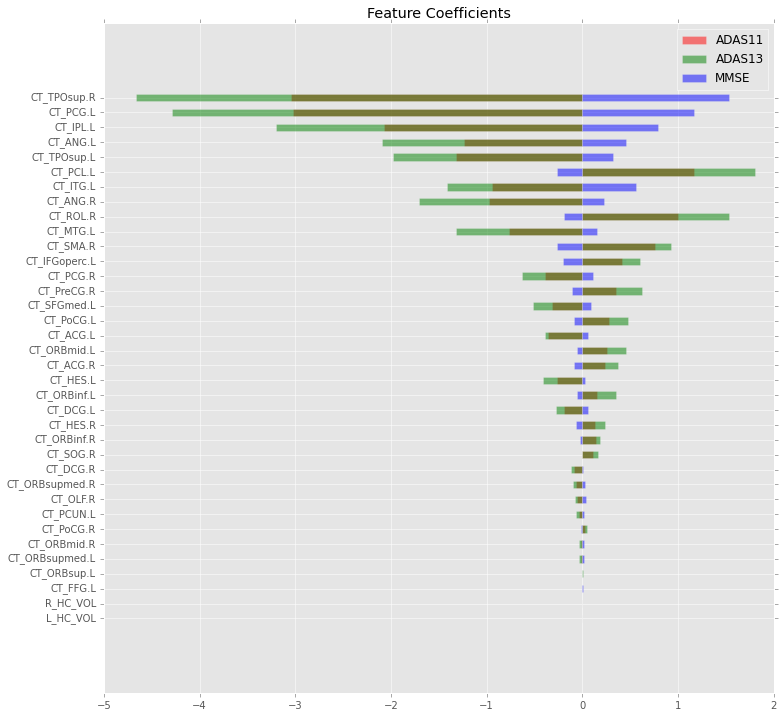

In [139]:
feats = zip(var_names, mean_coefs)
feats.sort(reverse=False, key=lambda x: np.sum(abs(x[1])))
feats = [feat for feat in feats if np.sum(abs(feat[1])) > 0.0]
coef_matrix = np.array(zip(*feats)[1])
# Plot the feature importances of the classifier
print '{} Features with non-zero coefficients:'.format(len(feats))
plt.figure()
plt.title("Feature Coefficients")
y_pos = np.arange(len(feats))

#print [coef for coef in zip(*feats)[1]]

plt.barh(y_pos, width=coef_matrix[:,0], height=0.5, color='r', align="center", alpha=0.5, label='{}'.format(clinical_scale[0]))
plt.barh(y_pos, width=coef_matrix[:,1], height=0.5, color='g', align="center", alpha=0.5, label='{}'.format(clinical_scale[1]))
plt.barh(y_pos, width=coef_matrix[:,2], height=0.5, color='b', align="center", alpha=0.5, label='{}'.format(clinical_scale[2]))
plt.yticks(y_pos, zip(*feats)[0])
plt.legend()
plt.show()

In [140]:
from sklearn.linear_model import Ridge

# Fit final model for testing
X_tv = np.concatenate([cv_data['X_train'][0], cv_data['X_valid'][0]], axis=0)
y_tv = np.concatenate([cv_data['y_train'][0], cv_data['y_valid'][0]], axis=0)

if BaseReg==linear_model.MultiTaskLasso:
    test_reg = Regression(alpha=best_alpha, normalize=False, fit_intercept=True)
else:
    test_reg = Regression(normalize=False, fit_intercept=True)

test_reg.fit(X_tv, y_tv)

In [141]:
X_t = test_data['X']
y_t = test_data['y']

y_hat_t=test_reg.predict(X_t)
R2 = r2_score(y_t, y_hat_t)
r = np.array([scipy.stats.pearsonr(y_t[:,i], y_hat_t[:,i]) for i in range(y_t.shape[1])])
rmse = np.array([np.sqrt(mean_squared_error(y_t[:,i], y_hat_t[:,i])) for i in range(y_t.shape[1])])
print R2
print rmse
print r

0.173273834102
[ 6.00808039  8.29164148  2.19216833]
[[  3.79633314e-01   4.30698328e-05]
 [  4.34150129e-01   2.15251361e-06]
 [  4.31701966e-01   2.49102743e-06]]


,Scale,RMSE,correlation,p-val
0,ADAS11,6.008080,0.379633,0.000043
1,ADAS13,8.291641,0.434150,0.000002
2,MMSE,2.192168,0.431702,0.000002


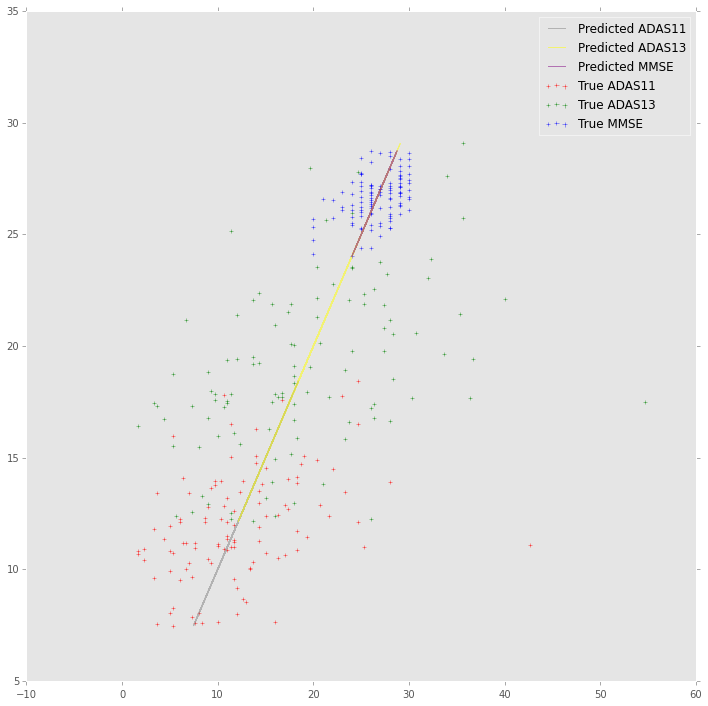

In [142]:
sca_col = {0: 'red', 1: 'green', 2: 'blue'}
line_col = {0: 'gray', 1: 'yellow', 2: 'purple'}

matrix = np.array([rmse, r[:,0], r[:,1]]).T
table = pd.DataFrame(matrix)
table.insert(0, 'Scale', clinical_scale)
table.columns = ['Scale', 'RMSE', 'correlation', 'p-val']
display(table)
for i, scale in enumerate(clinical_scale):
    ax=plt.subplot(1,1,1)
    plt.scatter(y_t[:,i], y_hat_t[:,i], marker='+', color=sca_col[i], alpha=.75, label='True {}'.format(scale))
    plt.plot(y_hat_t[:,i], y_hat_t[:,i], color=line_col[i], linewidth=1, alpha=0.5, label='Predicted {}'.format(scale))
plt.legend()
plt.grid()    
plt.show()